In [104]:


# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
# """
#     FindKey( BRW::HDF5.File, key::String ) -> aux::String
#         Find a key word into the HDF5 structure file and returns the path to the attribute or dataset
# """
# function FindKey( BRW::HDF5.File, key::String )
#     aux = [ ];
#     for i in BRW
#         if haskey( i, key )
#             aux = string( i );
#             groupaux = split( aux, " " )[ 2 ];
#             aux = string( groupaux, "/", key );
#         end
#     end
#     return aux
# end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #



# # •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
# """
#     SearchKey( key::String, Variables::Dict{Any, Any} ) -> OKPATH::String
# """
# function SearchKey( key::String, Variables::Dict{Any, Any} )
#     OKPATH = [ ];
#     K = string.( keys( Variables ) );
#     for k in K
#         AUX = split( k, "/" );
#         aux = match.( Regex(".+$key.+"), AUX );
#         if !isempty( findall( aux .!= nothing ) )
#              push!( OKPATH, join( AUX, "/" ) );
#         end
#     end
#     if isempty( OKPATH )
#         println( "There is no entry with the word $key" )
#     else
#         return OKPATH
#     end
# end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
using Statistics, StatsBase
function VoltageSaturation( HIthr, LOthr, porcentaje, data )
    # Toma los canales y frames con saturaciones y repara con la vecindad los que se pueden reparar
    # y los que no los vuelve 0 ( aquellos que estan mas del "porcentaje" de saturacion )
    # depende de las funciones saturacion y Neighborgs, y del paquete StatsBase
    porcentaje = porcentaje / 100;
    NOChs = [ ]; NOFrs = [ ]; # preallocation
    # Remover saturaciones positivas y negativas
    # obtener canales saturados para promediacion (Σ).
    ChFrSat = saturacion( data, HIthr, LOthr );
    # Aquellos saturados durante todo el bin son descartados de la lista (ChsGachos)) #
    Σ = zeros( Int, length( countmap( ChFrSat[ :, 1 ] ) ), 2 ); # preallocation
    Σ[ :, 1 ] = Int.( keys( countmap( ChFrSat[ :, 1 ] ) ) ); # que canales
    Σ[ :, 2 ] = Int.( values(countmap( ChFrSat[ :, 1 ] ) ) ); # cuantas veces
    # mas del 50% de frames saturados, se descarta el canal de la lista de promediación
    ChsGachos = Σ[ Σ[ :, 2 ] .>= Int( floor( porcentaje*size( data, 2 ) ) ), 1 ]; # los gachos
    push!( NOChs, ChsGachos ); # lista de todos los canales gachos
    #= obtener Frames saturados para promediacion (Φ).
    Aquellos saturados durante todo el bin son descartados de la lista (FrsGachos)) =#
    Φ = zeros( Int, length( countmap( ChFrSat[ :, 2 ] ) ), 2 ); # preallocation
    Φ[ :, 1 ] = Int.( keys( countmap( ChFrSat[ :, 2 ] ) ) ); # que Frames
    Φ[ :, 2 ] = Int.( values( countmap( ChFrSat[ :, 2 ] ) ) ); # cuantas veces
    # mas del 50% de canales saturados en ese frames (FrsGachos)...son gachos
    FrsGachos = Φ[ Φ[ :, 2 ] .>= Int( floor( porcentaje*size( data, 1 ) ) ), 1 ];
    push!( NOFrs, FrsGachos ); # lista de todos los frames gachos
    # Aquí se quitan los gachos de la lista de reparables
    # final list of channels
    ChFrSat = ChFrSat[ Bool.( 1 .- in.( ChFrSat[ :, 1 ], [ ChsGachos ] ) ), : ];
    # final list of Frames
    ChFrSat = ChFrSat[ Bool.( 1 .- in.( ChFrSat[ :, 2 ], [ FrsGachos ] ) ), : ];
    # ahora ChFrSat contiene solo los canales y frames saturados sin los gachos.
    # Osea, los que se pueden reparar
    for l = 1:size( ChFrSat, 1 )
        Ch = ChFrSat[ l, 1 ]; # channel and
        Fr = ChFrSat[ l, 2 ]; # frame for correction
        # Vecinos del canal gacho
        _, NeighChs = Neighbors( Ch, 1 );
        NeighChsFr = zeros( Int, length( NeighChs ), 2 ); #preallocation
        NeighChsFr[ :, 1 ] = NeighChs; # lista de vecinos
        # cada uno en el frame a promediar
        NeighChsFr[ :, 2 ] = repeat( [ Fr ], length( NeighChs ) );
        # Se remueven de la lista de vecinos los canales gachos
        NeighChsFr = NeighChsFr[
            Bool.( 1 .- in.( NeighChsFr[ :, 1 ], [ ChsGachos ] ) ), : ];
        #= Para evitar reparar el (canal,frame) con sus vecinos igual de saturados se
        remueven los voltajes  superiores a los umbrales establecidos de la lista de
        voltajes vecinos para promediacion =#
        if !isempty( NeighChsFr )
            NeighVoltage = data[ NeighChsFr ][ :, 1 ]; # voltejes de la vecindad
            NeighVoltage = NeighVoltage[
                Bool.( 1 .- ( LOthr .<=  NeighVoltage .>= HIthr ) )
                ]; # voltajes de la vecindad dentro de los umbrales
            if size( NeighVoltage, 1 ) >= 3 # minimo numero de vecinos para promediar
                global data[ Ch, Fr ] = mean( NeighVoltage );
            else
                #= Si no hay suficientes vecinos DENTRO del rango con quienes promediar,
                es mejor matarlo, creo. La otra opción sería promediar con los frames
                inmediatos no saturados del mismo canal...pero no estoy segura. =#
                global data[ Ch, Fr ] = 0;
            end
        else
        # Si no hay suficientes vecinos at all con quienes promediar, es mejor matarlo.
            global data[ Ch, Fr ] = sample( data[ Ch,: ] );
        end
    end
    # todos los canales gachos y todos los frames gachos se vuelven 0
    data[ ChsGachos, : ] .= 0; data[ :, FrsGachos ] .= 0;
    return data, NOChs, NOFrs
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
function saturacion( data::Array, HIthr::Int, LOthr::Int )
    # regresa que canal y en que frame hay saturaciones
    # ( cosas que se salen de los umbrales para arriba y abajo )
    saturados = vcat( findall( data .>= HIthr ),findall( data .<= LOthr ) );
    ChFrSat = zeros( Int, size( saturados, 1 ), 2 ); # preallocation
    if !isempty( saturados )
        for j = 1:size( saturados, 1 )
            ChFrSat[ j, 1 ] = saturados[ j ].I[ 1 ]; # channel
            ChFrSat[ j, 2 ] = saturados[ j ].I[ 2 ]; # Frame
        end
    end
    PSP = round(
        ( size( ChFrSat, 1 )*100 )/( size( data, 1 )*size( data, 2 ) ), digits = 2
        );
    println( string( " Hay ", PSP,"% de saturación." ) );
    return ChFrSat
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    Neighbors( C::Int64, d::Int64 ) -> A::Array{ Int64 }, v::Vector{ Int64 }
        A = Array( ( d*2 ) + 1, ( d * 2 ) + 1 ),
        v = vec( 2*( ( d * 2 ) + 1 ) - 1 );
        The d-Neighborhood is calculated from the channel ( C ) as a center
        A = array where C is the center and is in chip order
        v = same Neighboring channels as A but in vector form and without C ( 8 channels for d = 1 )
"""
function Neighbors( center::Int64, d::Int64 )
    Layout = reverse( reshape( collect( 1:4096 ), 64, 64 )', dims = 1 );
    x = findall( Layout .== center )[ ][ 2 ];
    y = findall( Layout .== center )[ ][ 1 ];
    aux = [ ( x - d ),( x + d ), ( y - d ), ( y + d ) ]
    aux[ aux .< 1 ] .= 1; aux[ aux .> 64 ] .= 64;
    A = Layout[ aux[ 3 ]:aux[ 4 ], aux[ 1 ]:aux[ 2 ] ];
    v = vec( A )[ vec( A ) .!= center ];
    return A, v
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
function saturacion( data::Array, HIthr::Int, LOthr::Int )
    # regresa que canal y en que frame hay saturaciones
    # ( cosas que se salen de los umbrales para arriba y abajo )
    saturados = vcat( findall( data .>= HIthr ),findall( data .<= LOthr ) );
    ChFrSat = zeros( Int, size( saturados, 1 ), 2 ); # preallocation
    if !isempty( saturados )
        ChFrSat = getindex.( saturados, [ 1 2 ] );
    end
    PSP = round(
        ( size( ChFrSat, 1 )*100 )/( size( data, 1 )*size( data, 2 ) ), digits = 2
        );
    println( string( " Hay ", PSP,"% de saturación." ) );
    return ChFrSat
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
using Plots
"""
    Z0( X::VecOrMat, nChs::Int64 ) -> Z::Matrix{Int64}
        using Plots
"""
function Z0( X::VecOrMat, nChs::Int64 )
    X = Int.( vec( X ) );
    Z = zeros( Int, nChs );
    n = Int( sqrt( nChs ) );
    Z[ X ] .= Z[ X ] .+ 1;
    Z = reverse( reshape( Z, n, n )', dims = 1 );
    return Int.( Z )
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    ZW( X::VecOrMat ) -> Z::Matrix{typeof(X)}
        using Plots
"""
function ZW( X::VecOrMat )
    X = vec( X );
    n = Int( sqrt( length( X ) ) );
    Z = reverse( reshape( X, n, n )', dims = 1 );
    return Z
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    Zplot( Z::Matrix, which::String, cm = :greys, nChs = 4096 ) -> F::Plot
        using Plots, MEATools.Z0, MEATools.ZW
"""
function Zplot( Z::VecOrMat, which::String, cm = :greys, nChs = 4096 )
    if which == "0"
        Z = Z0( Z, nChs ); 
    elseif which == "W"
        Z = ZW( Z );
    end
    F = heatmap( Z, aspect_ratio = 1, c = cm, axis = ( [ ], false ), wsize = ( 400, 400 ) );
    return F
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    ΔV( Variables::Dict{Any, Any}, BIN::Matrix{Float64}, ΔT::Int64 ) -> STD::Vector{Float64}
        using AccuraTools.ms2frames
"""
function ΔV( Variables::Dict{Any, Any}, BIN::Matrix{Float64}, ΔT::Int64 )
    ΔT = ms2frames( ΔT, Variables );
    STD = vec( std( ( BIN - circshift( BIN, ( 0, ΔT )  ) ), dims = 2 ) );
    return STD
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    ms2frames( time::Real, Variables::Dict{Any, Any} ) -> x::Float64
"""
function ms2frames( time::Real, Variables::Dict{Any, Any} )
    SamplingRate = Variables[ "SamplingRate" ];
    if time != 0; x = ceil( Int, ( time * SamplingRate ) / 1000 ); else; x = 1; end
    return x
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
using HistogramThresholding, ImageContrastAdjustment, Suppressor
"""
    Thresholding( W::VecOrMat ) -> Todos::Matrix{Int64}, T::Vector{Float64}
    using HistogramThresholding, ImageContrastAdjustment, Suppressor
"""
function Thresholding( W::VecOrMat )
    W = Float64.( vec( W ) );
    n = length( W );
    edges, conteo = HistogramThresholding.build_histogram( W, length( keys( countmap( W ) ) ) );
    t = zeros( 9 ); Todos = zeros( n, length( t ) );
    @suppress begin
        thr = find_threshold( UnimodalRosin( ), conteo[ 1:end ], edges );
        Todos[ W .>= thr, 1 ] .= 1; t[ 1 ] = thr;
        thr = find_threshold( MinimumIntermodes( ), conteo[ 1:end ], edges );
        Todos[ W .>= thr, 2 ] .= 1; t[ 2 ] = thr;
        thr = find_threshold( Intermodes( ), conteo[ 1:end ], edges );
        Todos[ W .>= thr, 3 ] .= 1; t[ 3 ] = thr;
        thr = find_threshold( MinimumError( ), conteo[ 1:end ], edges );
        Todos[ W .>= thr, 4 ] .= 1; t[ 4 ] = thr;
        thr = find_threshold( Moments( ), conteo[ 1:end ], edges );
        Todos[ W .>= thr, 5 ] .= 1; t[ 5 ] = thr;
        thr = find_threshold( Otsu( ), conteo[ 1:end ], edges );
        Todos[ W .>= thr, 6 ] .= 1; t[ 6 ] = thr;
        thr = find_threshold( Entropy( ), conteo[ 1:end ], edges );
        Todos[ W .>= thr, 7 ] .= 1; t[ 7 ] = thr;
        thr = find_threshold( Balanced( ), conteo[ 1:end ], edges );
        Todos[ W .>= thr, 8 ] .= 1; t[ 8 ] = thr;
        thr = find_threshold( Yen( ), conteo[ 1:end ], edges );
        Todos[ W .>= thr, 9 ] .= 1; t[ 9 ] = thr;
    end
    return Int.( Todos ), t
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    STExbin( bin::Vector{Float64}, thr::Real, parameters::Dict{String, Int64} ) -> Index::Vector{Int64}
"""
function STExbin( bin::Vector{Float64}, thr::Real, parameters::Dict{String, Int64} )
    distance = parameters[ "distance" ];
    ST = findall( bin .<= thr ); # eventos que pasan el umbral
    index_parcial = [ ];
    if !isempty( ST )
        a = 1;
        while a == 1
            distances = diff( ST ); # distancia entre ellos
            nears = findall( distances .<= distance ) .+ 1; # cuales estan cerca
            if isempty( nears )
                a = 0;
            else
                remove = zeros( Int, size( nears, 1 ) );
                for i = 1:size( nears, 1 )
                    # si el primero es menor que el segundo, quita el segundo
                    if isless( ( bin[ ST[ nears[ i ] ] ] ),
                            ( bin[ ST[ nears[ i ] - 1 ] ] ) )
                        remove[ i ] = nears[ i ] - 1;
                    else
                        remove[ i ] = nears[ i ];
                    end
                end
                if size( remove, 1 ) > 1
                    ST[ unique( remove ) ] .= 0;
                    filter!( x -> x != 0, ST );
                else
                    ST = ST[ Bool.( ST .!= ST[ remove[ 1 ] ] ) ];
                end
            end
        end
        push!( index_parcial, ST )
    else
        push!( index_parcial, [ ] )
    end
    return sort( unique( vcat( index_parcial... ) ) )
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    STExChannel( channel::Vector{Float64}, parameters::Dict{String, Int64} )
    -> thrs::Vector{Float64}, index_real::Vector{Inf64}
    using donoho, STExbin
"""
function STExChannel( channel::Vector{Float64}, parameters::Dict{String, Int64} )
    window = parameters[ "window" ];
    bit = parameters[ "bit" ];
    σ = parameters[ "cte" ];
    index_real = [ ];
    i = 1;
    I = Int( ( ( ( i - 1 ) * bit ) + 1 ) ); J = Int( I + window - 1 );
    thrs = [ ];
    thr = 0;
    while J <= ( length( channel ) - Int( window - 1 ) )
        bin = channel[ I:J ];
        if !iszero( bin )
            thr = -1*σ*abs( donoho( bin ) );
            index_parcial = STExbin( bin, thr, parameters );
            if !isempty( index_parcial )
                index_real = vcat( index_real, ( index_parcial .+ I .- 1 ) );
            end
        end
        i = i + 1;
        I = Int( ( ( ( i - 1 ) * bit ) + 1 ) ); J = Int( I + window - 1 );
    end
    index_real = unique( index_real );
    if !isempty( index_real )
        push!( thrs, thr )
    else
        push!( thrs, [0] )
    end
    return vcat( thrs... ), index_real
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
using Statistics
"""
    Noise-adaptive Optimal Thresholding
        donoho( x::Vector ) -> thr::Float64
        using Statistics
"""
@inline donoho( x ) = ( median( abs.( x ) ) / 0.6745 );
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
using DSP
"""
    FiltMUAremez( Variables::Dict{Any, Any}, channel::Vector{Float64} -> MUA::Vector{Float64}
    using DSP
"""
function FiltMUAremez( Variables::Dict{Any, Any}, channel::Vector{Float64} )
    lF = 300;
    fac = 10;
    HF = 3000;
    SamplingRate = Variables[ "SamplingRate" ];
    NYQ = floor( Int, SamplingRate / 2 );
    order = Int( floor( ( SamplingRate / lF ) / 5 ) );
    bpass = remez(
        ( order + 1 ), [ ( 0, lF - fac ) => 0, ( lF, HF ) => 1, ( HF + fac, NYQ ) => 0 ],
            Hz = SamplingRate );
    MUA = filtfilt( DSP.Filters.PolynomialRatio( bpass, [ 1.0 ] ), channel );
    return MUA
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    FilteringMatrix( data::Matrix{Float64}, Variables::Dict{Any, Any} ) -> datafilt::Matrix{Float64}
    using FiltroMUAremez
"""
function FilteringMatrix( data::Matrix{Float64}, Variables::Dict{Any, Any} )
    datafilt = copy( data );
    for k = 1:size( data, 1 )
        channel = data[ k, : ];
        MUA = FiltMUAremez( Variables, channel );
        datafilt[ k, : ] = MUA;
    end
    return datafilt
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    StaticThresholdEvents( channel::Vector{Float64}, thr::Real, parameters::Dict{String, Int64} )
    -> index::Vector{Int64}
    Index of detected suprathreshold events with a pre-established threshold
    using STExbin
"""
function StaticThresholdEvents( channel::Vector{Float64}, thr::Real, parameters::Dict{String, Int64} )
    index = STExbin( channel, thr, parameters );
    return index
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

"""
    neighborgs( C::Int64, d::Int64 ) ->
        -> A = Array( ( d*2 ) + 1, ( d * 2 ) + 1 ), v = vec( 2*( ( d * 2 ) + 1 ) - 1 );
        The d-neighborhood is calculated from the channel (C) as a center
        A = array where C is the center and is in chip order
        v = same neighboring channels as A but in vector form and without C ( 8 channels )
"""
function neighborgs( C::Int64, d::Int64 )
    Layout = reverse( reshape( collect( 1:4096 ), 64, 64 )', dims = 1 );
    x_c = findall( Layout .== C )[ ][ 2 ]; y_c = findall( Layout .== C )[ ][ 1 ];
    aux = [ ( x_c - d ),( x_c + d ), ( y_c - d ), ( y_c + d ) ]
    aux[ aux .< 1 ] .= 1; aux[ aux .> 64 ] .= 64;
    A = Layout[ aux[ 3 ]:aux[ 4 ], aux[ 1 ]:aux[ 2 ] ];
    v = vec( A )[ vec( A ) .!= C ];
    return A, v
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
function FigureGroups( grupos::Vector, loose::Vector = [ ], cm = :twilight )
    Z = zeros( Int, 4096 );
    for i = 1:size( grupos, 1 )
        Z[ grupos[ i ] ] .= floor( Int, log( length( grupos[ i ] ) ) ) + 2 ;
    end
    Z[ Int.( loose ) ] .= 1
    Z = reverse( reshape( Z, 64, 64 )', dims = 1 )
    F = heatmap(
        Z,
        aspect_ratio = 1,
        c = cm,
        axis = ( [ ], false ),
        wsize = ( 400, 400 ),
        cbar = :none );
    return F
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    ThresholdingPlots( Todos::Matrix{Int64} ) -> TF::Plot
    using MeaTools.Zplot, Plots
"""
function ThresholdingPlots( Todos::Matrix{Int64} )
    xmessage = string( "UnimodalRosin : ", length( findall( Todos[ :, 1 ] .== 1 ) )," channels" );
    T1 = Zplot( Todos[ :, 1 ], "W" ); T1 = plot!( title = xmessage, cbar = :none );
    xmessage = string( "MinimumIntermodes: ", length( findall( Todos[ :, 2 ] .== 1 ) )," channels" );
    T2 = Zplot( Todos[ :, 2 ], "W" ); T2 = plot!( title = xmessage, cbar = :none );
    xmessage = string( "Intermodes: ", length( findall( Todos[ :, 3 ] .== 1 ) )," channels" );
    T3 = Zplot( Todos[ :, 3 ], "W" ); T3 = plot!( title = xmessage, cbar = :none );
    xmessage = string( "MinimumError: ", length( findall( Todos[ :, 4 ] .== 1 ) )," channels" );
    T4 = Zplot( Todos[ :, 4 ], "W" ); T4 = plot!( title = xmessage, cbar = :none );
    xmessage = string( "Moments: ", length( findall( Todos[ :, 5 ] .== 1 ) )," channels" );
    T5 = Zplot( Todos[ :, 5 ], "W" ); T5 = plot!( title = xmessage, cbar = :none );
    xmessage = string( "Otsu: ", length( findall( Todos[ :, 6 ] .== 1 ) )," channels" );
    T6 = Zplot( Todos[ :, 6 ], "W" ); T6 = plot!( title = xmessage, cbar = :none );
    xmessage = string( "Entropy: ", length( findall( Todos[ :, 7 ] .== 1 ) )," channels" );
    T7 = Zplot( Todos[ :, 7 ], "W" ); T7 = plot!( title = xmessage, cbar = :none );
    xmessage = string( "Balanced: ", length( findall( Todos[ :, 8 ] .== 1 ) )," channels" );
    T8 = Zplot( Todos[ :, 8 ], "W" ); T8 = plot!( title = xmessage, cbar = :none );
    xmessage = string( "Yen: ", length( findall( Todos[ :, 9 ] .== 1 ) )," channels" );
    T9 = Zplot( Todos[ :, 9 ], "W" ); T9 = plot!( title = xmessage, cbar = :none );

    TF = plot(
        T1, T2, T3, T4, T5, T6, T7, T8, T9,
        layout = ( 3, 3 ), wsize = ( 700, 700 ), titlefont = ( 8, "arial" ) );
    return TF
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
"""
    FillingHolesCrux( Seleccion::Vector{Int64} ) -> NewSelection::Vector{Int64}
        using MeaTools.neighborgs
"""
function FillingHolesCrux( Seleccion::Vector{Int64} )
    Z = reverse( reshape( 1:4096, 64, 64 )', dims = 1 );
    arriba = Z[ 64, 2:( end - 1 ) ]; abajo = Z[ 1, 2:( end - 1 ) ];
    izquierda = Z[ 2:( end - 1 ), 1 ]; derecha = Z[ 2:( end - 1 ), 64 ];
    esquinas = vcat( Z[ 1, 1 ], Z[ 64, 64 ], Z[ 64, 1 ], Z[ 1, 64 ] );
    bordes = vcat( arriba, abajo, izquierda, derecha, esquinas );
    bordes_noesquinas = vcat( arriba, abajo, izquierda, derecha );
    P = true
    while P
        X1 = setdiff( setdiff( setdiff( 1:4096, Seleccion ) ), bordes );
        p1 = [ ];
        for i = 1:length( X1 )
            x = X1[ i ];
            A, _ = neighborgs( x, 1 );
            CruzH = [ A[ 2, 1 ], A[ 2, 3 ] ];
            CruzV = [ A[ 1, 2 ], A[ 3, 2 ] ];
            x1 = length( CruzH[ CruzH .∈ [ Seleccion ] ] ) == 2;
            x2 = length( CruzV[ CruzV .∈ [ Seleccion ] ] ) == 2;
            if ( x1 || x2 )
                push!( p1, x )
            end
        end
        X1 = intersect( arriba, setdiff( setdiff( 1:4096, Seleccion ) ) );
        p2 = [ ];
        for i = 1:length( X1 )
            x = X1[ i ];
            A, _ = neighborgs( x, 1 );
                Cruz = [ A[ 2, 1 ], A[ 2, 3 ] ];
                x1 = length( Cruz[ Cruz .∈ [ Seleccion ] ] ) == 2;
            if x1
                push!( p2, x )
            end
        end
        X1 = intersect( abajo, setdiff( setdiff( 1:4096, Seleccion ) ) );
        p3 = [ ];
        for i = 1:length( X1 )
            x = X1[ i ];
            A, _ = neighborgs( x, 1 );
                Cruz = [ A[ 1, 1 ], A[ 1, 3 ] ];
                x1 = length( Cruz[ Cruz .∈ [ Seleccion ] ] ) == 2;
            if x1
                push!( p3, x )
            end
        end
        X1 = intersect( vcat( izquierda, derecha ), setdiff( setdiff( 1:4096, Seleccion ) ) );
        p4 = [ ];
        for i = 1:length( X1 )
            x = X1[ i ];
            A, _ = neighborgs( x, 1 );
                Cruz = [ A[ 1, 2 ], A[ 3, 2 ] ];
                x1 = length( Cruz[ Cruz .∈ [ Seleccion ] ] ) == 2;
            if x1
                push!( p4, x )
            end
        end
        X1 = intersect( esquinas, setdiff( setdiff( 1:4096, Seleccion ) ) );
        p5 = [ ];
        for i = 1:length( X1 )
            x = X1[ i ];
            _, v = neighborgs( x, 1 );
            if length( v[ v .∈ [ Seleccion ] ] ) >= 2
               push!( p5, x )
            end
        end
        posibles = [ ];
        posibles = vcat( Int.( p1 ), Int.( p2 ), Int.( p3 ), Int.( p4 ), Int.( p5 ) );
        if isempty( posibles )
            P = false
        else
            Seleccion = vcat( posibles, Seleccion );
        end
    end
    return Int.( Seleccion )
end
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

neighborgs

In [30]:
using Plots

In [2]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

FILEBRW = "/run/media/isabel/Data/Hipocampo/Espontanea/01-06-2022/BRWs/Phase_10.brw";

# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

In [6]:
Variables, FILEPATHS = GetVarsHDF5( FILEBRW );

You are now working on the new main path: /run/media/isabel/Data/Hipocampo/Espontanea/01-06-2022/BRWs/Phase_10
With the file: 
Phase_10.brw : BRW-File Level3 - 3Brain RaW data file for high resolution MEA platform, HDF5-format - Created with BrainWave v.4.5.8180.23837 on date Wednesday, June 1, 2022 HDF5 file size: 25.7256636640625 GB


In [7]:
limupper = 0.4
σ = ChunkSizeSpace( Variables, limupper );

65 segments of 0.3957794409855769 GB each one


In [13]:
nBIN = 1;

BIN = OneSegment( Variables, nBIN, σ );
BIN = Digital2Analogue( Variables, BIN );

LowThr = -2500;
HigThr = 2500;
Percentage = 15;
BIN, NOChs, NOFrs = VoltageSaturation( HigThr, LowThr, Percentage, BIN );

 Hay 0.16% de saturación.


In [14]:
DiscardedChannels = sort( vcat( NOChs... ) );

In [ ]:
BINfilt = FilteringMatrix( BIN, Variables );

In [58]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
# ACD-01 
ΔT = 400; # ms
lims = [ 300, 1200 ]; # channels
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
ΔV01 = ΔV( Variables, BIN, ΔT );
ΔV01[ DiscardedChannels ] .= 0;
ΔV01log = log.( ΔV01 );
ΔV01log0 = copy( ΔV01log ); 
ΔV01log0[ ΔV01log0 .== -Inf ] .= 0;
cm = reverse(colormap( "RdBu", length( countmap( ΔV01 ) ); mid = 0.5, logscale = false ) );
P1 = Zplot( ΔV01, "W", cm ); P1 = title!( "ΔV, with ΔT = $ΔT" )
cm = reverse(colormap( "RdBu", length( countmap( ΔV01log ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( ΔV01log, "W", cm ); P2 = title!( "log(ΔV), with ΔT = $ΔT" )
cm = reverse(colormap( "RdBu", length( countmap( ΔV01log0 ) ); mid = 0.4, logscale = false ) );
P3 = Zplot( ΔV01log0, "W", cm ); P3 = title!( "log(ΔV) Norm, with ΔT = $ΔT" )
plot( )
F1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 10 );
TΔV01, tΔV01 = Thresholding( ΔV01 ); aux = vec( sum( TΔV01, dims = 1 ) );
NewT = TΔV01[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTΔV01 = findall( aux .== maximum( aux ) );
TΔV01log, tΔV01log = Thresholding( ΔV01log ); aux = vec( sum( TΔV01log, dims = 1 ) );
NewT = TΔV01log[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTΔV01log = findall( aux .== maximum( aux ) );
TΔV01log0, tΔV01log0 = Thresholding( ΔV01log0 ); aux = vec( sum( TΔV01log0, dims = 1 ) );
NewT = TΔV01log0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTΔV01log0 = findall( aux .== maximum( aux ) );
P1 = Zplot( SelectedChannelsTΔV01, "0" ); P1 = title!( "Thresholding ΔV, with ΔT = $ΔT" );
P2 = Zplot( SelectedChannelsTΔV01log, "0" ); P2 = title!( "Thresholding log(ΔV), with ΔT = $ΔT" );
P3 = Zplot( SelectedChannelsTΔV01log0, "0" ); P3 = title!( "Thresholding log(ΔV) Norm, with ΔT = $ΔT" );
plot( )
F2 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
#
ΔV01F = ΔV( Variables, BINfilt, ΔT );
ΔV01F[ DiscardedChannels ] .= 0;
ΔV01Flog = log.( ΔV01F );
ΔV01Flog0 = copy( ΔV01Flog ); 
ΔV01Flog0[ ΔV01Flog0 .== -Inf ] .= 0;
cm = reverse(colormap( "RdBu", length( countmap( ΔV01F ) ); mid = 0.5, logscale = false ) );
P1 = Zplot( ΔV01F, "W", cm ); P1 = title!( "ΔV filt, with ΔT = $ΔT" )
cm = reverse(colormap( "RdBu", length( countmap( ΔV01Flog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( ΔV01Flog, "W", cm ); P2 = title!( "log( ΔV filt ), with ΔT = $ΔT" )
cm = reverse(colormap( "RdBu", length( countmap( ΔV01Flog0 ) ); mid = 0.4, logscale = false ) );
P3 = Zplot( ΔV01Flog0, "W", cm ); P3 = title!( "log( ΔV filt ) Norm, with ΔT = $ΔT" )
plot( )
F9 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 10 );
TΔV01F, tΔV01F = Thresholding( ΔV01F ); aux = vec( sum( TΔV01F, dims = 1 ) );
NewT = TΔV01F[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTΔV01F = findall( aux .== maximum( aux ) );
TΔV01Flog, tΔV01Flog = Thresholding( ΔV01Flog ); aux = vec( sum( TΔV01Flog, dims = 1 ) );
NewT = TΔV01Flog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTΔV01Flog = findall( aux .== maximum( aux ) );
TΔV01Flog0, tΔV01Flog0 = Thresholding( ΔV01Flog0 ); aux = vec( sum( TΔV01Flog0, dims = 1 ) );
NewT = TΔV01Flog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTΔV01Flog0 = findall( aux .== maximum( aux ) );
P1 = Zplot( SelectedChannelsTΔV01F, "0" ); P1 = title!( "Thresholding ΔV, with ΔT = $ΔT" );
P2 = Zplot( SelectedChannelsTΔV01Flog, "0" ); P2 = title!( "Thresholding log(ΔV), with ΔT = $ΔT" );
P3 = Zplot( SelectedChannelsTΔV01Flog0, "0" ); P3 = title!( "Thresholding log(ΔV) Norm, with ΔT = $ΔT" );
plot( )
F10 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );

In [44]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
# ACD-02 Event detection
window = 5 # ms
bit = 1 # ms
distance = 0.4 # ms
σ = 4; # 4 / sqrt( 3 );
nChs = size( BIN, 1 );
channels = collect( 1:nChs );
ValidChannels = setdiff( channels, DiscardedChannels );
window = ms2frames( window, Variables );
bit = ms2frames( bit, Variables );
distance = ms2frames( distance, Variables );
parameters = Dict(
    "window"    => window,
    "bit"      => bit,
    "distance"  => distance,
    "cte"       => σ
);
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
TotalBoth = zeros( Int, nChs );
EventsFilt = [ ]
EventsRaw = [ ]
Both = [ ]
ThrsFilt = [ ]
ThrsRaw = [ ]
for i in channels
    channelfilt = BINfilt[ i, : ];
    channelraw = BIN[ i, : ];
    thrsFilt, IndexFilt = STExChannel( channelfilt, parameters );
    thrsRaw, IndexRaw = STExChannel( channelraw, parameters );
    TotalBoth[ i ] = length( intersect( IndexFilt, IndexRaw ) );
    EventsFilt = push!( EventsFilt, IndexFilt );
    ThrsFilt = push!( ThrsFilt, thrsFilt );
    EventsRaw = push!( EventsRaw, IndexRaw );
    ThrsRaw = push!( ThrsRaw, thrsRaw );
end
DTEFilt = length.( EventsFilt ); DTERaw = length.( EventsRaw ); DTEFiltlog = log.( DTEFilt );
DTEFiltlog0 = copy( DTEFiltlog ); DTEFiltlog0[ DTEFiltlog0 .== -Inf ] .= 0;
DTERawlog = log.( DTERaw ); DTERawlog0 = copy( DTERawlog ); DTERawlog0[ DTERawlog0 .== -Inf ] .= 0;
thr = -60;
STERaw = zeros( Int, nChs ); STEFilt = zeros( Int, nChs );
indexRaw = [ ]; indexFilt = [ ];
for i in channels
    channel = BIN[ i, : ]
    index = StaticThresholdEvents( channel, thr, parameters );
    if !isempty( index )
        STERaw[ i ] = length( index );
        push!( indexRaw, index );
    end
    channel = BINfilt[ i, : ];
    index = StaticThresholdEvents( channel, thr, parameters );
    if !isempty( index )
        STEFilt[ i ] = length( index );
        push!( indexFilt, index );
    end
end
STEFiltlog = log.( STEFilt ); STEFiltlog0 = copy( STEFiltlog ); STEFiltlog0[ STEFiltlog0 .== -Inf ] .= 0;
STERawlog = log.( STERaw ); STERawlog0 = copy( STERawlog ); STERawlog0[ STERawlog0 .== -Inf ] .= 0;
#
cm = reverse( colormap( "RdBu", length(unique(DTEFilt)); mid = 0.6, logscale = false ) );
P1 = Zplot( DTEFilt, "W", cm ); P1 = title!( "Events DT Filt" )
cm = reverse( colormap( "RdBu", length( countmap( DTEFiltlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( DTEFiltlog, "W", cm ); P2 = title!( "log( Events DT Filt )" )
cm = reverse( colormap( "RdBu", length( countmap( DTEFiltlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( DTEFiltlog0, "W", cm ); P3 = title!( "log( Events DT Filt ) Norm" )
plot( )
F2_1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
cm = reverse( colormap( "RdBu", length( unique( DTERaw ) ); mid = 0.6, logscale = false ) );
P1 = Zplot( DTERaw, "W", cm ); P1 = title!( "Events DT Raw" )
cm = reverse( colormap( "RdBu", length( countmap( DTERawlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( DTERawlog, "W", cm ); P2 = title!( "log( Events DT Raw )" )
cm = reverse( colormap( "RdBu", length( countmap( DTERawlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( DTERawlog0, "W", cm ); P3 = title!( "log( Events DT Raw ) Norm" )
plot( )
F2_2 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
cm = reverse( colormap( "RdBu", length( unique( STEFilt ) ); mid = 0.6, logscale = false ) );
P1 = Zplot( STEFilt, "W", cm ); P1 = title!( "Events ST Filt" )
cm = reverse( colormap( "RdBu", length( countmap( STEFiltlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( STEFiltlog, "W", cm ); P2 = title!( "log( Events ST Filt )" )
cm = reverse( colormap( "RdBu", length( countmap( STEFiltlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( STEFiltlog0, "W", cm ); P3 = title!( "log( Events ST Filt ) Norm" )
plot( )
F2_3 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
cm = reverse( colormap( "RdBu", length( unique( STERaw ) ); mid = 0.6, logscale = false ) );
P1 = Zplot( STERaw, "W", cm ); P1 = title!( "Events ST Raw" )
cm = reverse( colormap( "RdBu", length( countmap( STERawlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( STERawlog, "W", cm ); P2 = title!( "log( Events ST Raw )" )
cm = reverse( colormap( "RdBu", length( countmap( STERawlog0 ) ); mid = 0.2, logscale = false ) );
P3 = Zplot( STERawlog0, "W", cm ); P3 = title!( "log( Events ST Raw ) Norm" )
plot( )
F2_4 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
plot( )
F3 = plot( F2_1, F2_2, F2_3, F2_4, layout = ( 4, 1 ), wsize = ( 800, 800 ) );
#
TSTERaw, tSTERaw = Thresholding( STERaw ); aux = vec( sum( TSTERaw, dims = 1 ) );
lims = [ 300, 1200 ]; # channels
NewT = TSTERaw[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTERaw = findall( aux .== maximum( aux ) );
TSTERawlog, tSTERawlog = Thresholding( STERawlog ); aux = vec( sum( TSTERawlog, dims = 1 ) );
NewT = TSTERawlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTERawlog = findall( aux .== maximum( aux ) );
TSTERawlog0, tSTERawlog0 = Thresholding( STERawlog0 ); aux = vec( sum( TSTERawlog0, dims = 1 ) );
NewT = TSTERawlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTERawlog0 = findall( aux .== maximum( aux ) );
TSTEFilt, tSTEFilt = Thresholding( STEFilt ); aux = vec( sum( TSTEFilt, dims = 1 ) );
NewT = TSTEFilt[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTEFilt = findall( aux .== maximum( aux ) );
TSTEFiltlog, tSTEFiltlog = Thresholding( STEFiltlog ); aux = vec( sum( TSTEFiltlog, dims = 1 ) );
NewT = TSTEFiltlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTEFiltlog = findall( aux .== maximum( aux ) );
TSTEFiltlog0, tSTEFiltlog0 = Thresholding( STEFiltlog0 ); aux = vec( sum( TSTEFiltlog0, dims = 1 ) );
NewT = TSTEFiltlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTEFiltlog0 = findall( aux .== maximum( aux ) );
TDTERaw, tDTERaw = Thresholding( DTERaw ); aux = vec( sum( TDTERaw, dims = 1 ) );
NewT = TDTERaw[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTDTERaw = findall( aux .== maximum( aux ) );
TDTERawlog, tDTERawlog = Thresholding( DTERawlog ); aux = vec( sum( TDTERawlog, dims = 1 ) );
NewT = TDTERawlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTDTERawlog = findall( aux .== maximum( aux ) );
TDTERawlog0, tDTERawlog0 = Thresholding( DTERawlog0 ); aux = vec( sum( TDTERawlog0, dims = 1 ) );
NewT = TDTERawlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTDTERawlog0 = findall( aux .== maximum( aux ) );
TDTEFilt, tDTEFilt = Thresholding( DTEFilt ); aux = vec( sum( TDTEFilt, dims = 1 ) );
NewT = TDTEFilt[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTDTEFilt = findall( aux .== maximum( aux ) );
TDTEFiltlog, tDTEFiltlog = Thresholding( DTEFiltlog ); aux = vec( sum( TDTEFiltlog, dims = 1 ) );
NewT = TDTEFiltlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTDTEFiltlog = findall( aux .== maximum( aux ) );
TDTEFiltlog0, tDTEFiltlog0 = Thresholding( DTEFiltlog0 ); aux = vec( sum( TDTEFiltlog0, dims = 1 ) );
NewT = TDTEFiltlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTDTEFiltlog0 = findall( aux .== maximum( aux ) );
#
P1 = Zplot( SelectedChannelsTSTERaw, "0" ); P1 = title!( "Thresholding ST Raw" );
P2 = Zplot( SelectedChannelsTSTERawlog, "0" ); P2 = title!( "Thresholding log( ST Raw )" );
P3 = Zplot( SelectedChannelsTSTERawlog0, "0" ); P2 = title!( "Thresholding log( ST Raw ) Norm" );
plot( )
F3_1 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
P1 = Zplot( SelectedChannelsTSTEFilt, "0" ); P1 = title!( "Thresholding ST Filt" );
P2 = Zplot( SelectedChannelsTSTEFiltlog, "0" ); P2 = title!( "Thresholding log( ST Filt )" );
P3 = Zplot( SelectedChannelsTSTEFiltlog0, "0" ); P3 = title!( "Thresholding log( ST Filt ) Norm" );
plot( )
F3_2 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
P1 = Zplot( SelectedChannelsTDTERaw, "0" ); P1 = title!( "Thresholding DT Raw" );
P2 = Zplot( SelectedChannelsTDTERawlog, "0" ); P2 = title!( "Thresholding log( DT Raw )" );
P3 = Zplot( SelectedChannelsTDTERawlog0, "0" ); P2 = title!( "Thresholding log( DT Raw ) Norm" );
plot( )
F3_3 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
P1 = Zplot( SelectedChannelsTDTEFilt, "0" ); P1 = title!( "Thresholding DT Filt" );
P2 = Zplot( SelectedChannelsTDTEFiltlog, "0" ); P2 = title!( "Thresholding log( DT Filt )" );
P3 = Zplot( SelectedChannelsTDTEFiltlog0, "0" ); P3 = title!( "Thresholding log( DT Filt ) Norm" );
plot( )
F3_4 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
F4 = plot( F3_4, F3_3, F3_2, F3_1, wsize = ( 800, 800 ), layout = ( 4, 1 ), cbar = :none, titlefont = 8 );
#

In [89]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
# ACD 03. 
nChs = size( BIN, 1 );
lims = [ 300, 1200 ]; # channels
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
V = zeros( Int, nChs ); # preallocation
[ V[ k ] = length( unique( BIN[ k, : ] ) ) for k in channels ];
#
Vlog = log.( V );
Vlog0 = copy( Vlog ); Vlog0[ Vlog0 .== -Inf ] .= 0;
cm = reverse( colormap( "RdBu", length( countmap( V ) ); mid = 0.4, logscale = false ) );
P1 = Zplot( V, "W", cm ); P1 = title!( "Variability" )
cm = reverse(colormap( "RdBu", length( countmap( Vlog ) ); mid = 0.4, logscale = false ) );
P2 = Zplot( Vlog, "W", cm ); P2 = title!( "log( Variability )" )
cm = reverse(colormap( "RdBu", length( countmap( Vlog0 ) ); mid = 0.4, logscale = false ) );
P3 = Zplot( Vlog0, "W", cm ); P3 = title!( "log( Variability ) Norm" )
plot( )
F5 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 )
TV, tV = Thresholding( V ); aux = vec( sum( TV, dims = 1 ) );
NewT = TV[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTV = findall( aux .== maximum( aux ) );
TVlog, tVlog = Thresholding( Vlog ); aux = vec( sum( TVlog, dims = 1 ) );
NewT = TVlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTVlog = findall( aux .== maximum( aux ) );
TVlog0, tVlog0 = Thresholding( Vlog0 ); aux = vec( sum( TVlog0, dims = 1 ) );
NewT = TVlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTVlog0 = findall( aux .== maximum( aux ) );
P1 = Zplot( SelectedChannelsTV, "0" ); P1 = title!( "Thresholding Variability" );
P2 = Zplot( SelectedChannelsTVlog, "0" ); P2 = title!( "Thresholding log( Var )" );
P3 = Zplot( SelectedChannelsTVlog0, "0" ); P3 = title!( "Thresholding log( Var ) Norm" );
plot( )
F6 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );
#
VF = zeros( Int, nChs ); # preallocation
[ VF[ k ] = length( unique( BINfilt[ k, : ] ) ) for k in channels ];
#
VFlog = log.( VF );
VFlog0 = copy( VFlog ); VFlog0[ VFlog0 .== -Inf ] .= 0;
cm = reverse( colormap( "RdBu", length( countmap( VF ) ); mid = 0.4, logscale = false ) );
P1 = Zplot( VF, "W", cm ); P1 = title!( "VFariability Filter" )
cm = reverse(colormap( "RdBu", length( countmap( VFlog ) ); mid = 0.4, logscale = false ) );
P2 = Zplot( VFlog, "W", cm ); P2 = title!( "log( VFariability Filter )" )
cm = reverse(colormap( "RdBu", length( countmap( VFlog0 ) ); mid = 0.4, logscale = false ) );
P3 = Zplot( VFlog0, "W", cm ); P3 = title!( "log( VFariability Filter ) Norm" )
plot( )
F7 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 )
TVF, tVF = Thresholding( VF ); aux = vec( sum( TVF, dims = 1 ) );
NewT = TVF[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTVF = findall( aux .== maximum( aux ) );
TVFlog, tVFlog = Thresholding( VFlog ); aux = vec( sum( TVFlog, dims = 1 ) );
NewT = TVFlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTVFlog = findall( aux .== maximum( aux ) );
TVFlog0, tVFlog0 = Thresholding( VFlog0 ); aux = vec( sum( TVFlog0, dims = 1 ) );
NewT = TVFlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTVFlog0 = findall( aux .== maximum( aux ) );
P1 = Zplot( SelectedChannelsTVF, "0" ); P1 = title!( "Thresholding VFar F " );
P2 = Zplot( SelectedChannelsTVFlog, "0" ); P2 = title!( "Thresholding log( VFar F )" );
P3 = Zplot( SelectedChannelsTVFlog0, "0" ); P3 = title!( "Thresholding log( VFar F ) Norm" );
plot( )
F8 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );

In [90]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
# ACD 04.
nChs = size( BIN, 1 );
lims = [ 300, 1200 ]; # channels
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
STD = zeros( Float64, nChs ); # preallocation
[ STD[ k ] = std( BIN[ k, : ] ) for k in channels ];
STDlog = log.( STD );
STDlog0 = copy( STDlog ); STDlog0[ STDlog0 .== -Inf ] .= 0;
cm = reverse(colormap( "RdBu", length( countmap( STD ) ); mid = 0.5, logscale = false ) );
P1 = Zplot( STD, "W", cm ); P1 = title!( "STD" )
cm = reverse(colormap( "RdBu", length( countmap( STDlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( STDlog, "W", cm ); P2 = title!( "log( STD )" )
cm = reverse(colormap( "RdBu", length( countmap( STDlog0 ) ); mid = 0.4, logscale = false ) );
P3 = Zplot( STDlog0, "W", cm ); P3 = title!( "log( STD ) Norm" )
plot( )
F11 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 10 )
TSTD, tSTD = Thresholding( STD ); aux = vec( sum( TSTD, dims = 1 ) );
NewT = TSTD[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTD = findall( aux .== maximum( aux ) );
TSTDlog, tSTDlog = Thresholding( STDlog ); aux = vec( sum( TSTDlog, dims = 1 ) );
NewT = TSTDlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTDlog = findall( aux .== maximum( aux ) );
TSTDlog0, tSTDlog0 = Thresholding( STDlog0 ); aux = vec( sum( TSTDlog0, dims = 1 ) );
NewT = TSTDlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTDlog0 = findall( aux .== maximum( aux ) );
P1 = Zplot( SelectedChannelsTSTD, "0" ); P1 = title!( "Thresholding STD" );
P2 = Zplot( SelectedChannelsTSTDlog, "0" ); P2 = title!( "Thresholding log( STD )" );
P3 = Zplot( SelectedChannelsTSTDlog0, "0" ); P3 = title!( "Thresholding log( STD ) Norm" );
plot( )
F12 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 )
#
STDF = zeros( Float64, nChs ); # preallocation
[ STDF[ k ] = std( BINfilt[ k, : ] ) for k in channels ];
STDFlog = log.( STDF );
STDFlog0 = copy( STDFlog ); STDFlog0[ STDFlog0 .== -Inf ] .= 0;
cm = reverse(colormap( "RdBu", length( countmap( STDF ) ); mid = 0.5, logscale = false ) );
P1 = Zplot( STDF, "W", cm ); P1 = title!( "STDF filt" )
cm = reverse(colormap( "RdBu", length( countmap( STDFlog ) ); mid = 0.3, logscale = false ) );
P2 = Zplot( STDFlog, "W", cm ); P2 = title!( "log( STDF filt )" )
cm = reverse(colormap( "RdBu", length( countmap( STDFlog0 ) ); mid = 0.4, logscale = false ) );
P3 = Zplot( STDFlog0, "W", cm ); P3 = title!( "log( STDF filt ) Norm" )
plot( )
F13 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 10 )
TSTDF, tSTDF = Thresholding( STDF ); aux = vec( sum( TSTDF, dims = 1 ) );
NewT = TSTDF[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTDF = findall( aux .== maximum( aux ) );
TSTDFlog, tSTDFlog = Thresholding( STDFlog ); aux = vec( sum( TSTDFlog, dims = 1 ) );
NewT = TSTDFlog[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTDFlog = findall( aux .== maximum( aux ) );
TSTDFlog0, tSTDFlog0 = Thresholding( STDFlog0 ); aux = vec( sum( TSTDFlog0, dims = 1 ) );
NewT = TSTDFlog0[ :, lims[ 2 ] .>= aux .>= lims[ 1 ] ]; aux = vec( sum( NewT, dims = 2 ) );
SelectedChannelsTSTDFlog0 = findall( aux .== maximum( aux ) );
P1 = Zplot( SelectedChannelsTSTDF, "0" ); P1 = title!( "Thresholding STDF filt" );
P2 = Zplot( SelectedChannelsTSTDFlog, "0" ); P2 = title!( "Thresholding log( STDF filt )" );
P3 = Zplot( SelectedChannelsTSTDFlog0, "0" ); P3 = title!( "Thresholding log( STDF filt ) Norm" );
plot( )
F14 = plot( P1, P2, P3, wsize = ( 900, 400 ), layout = ( 1, 3 ), cbar = :none, titlefont = 8 );

In [173]:
WF = log.(STDF) + log.(STD) + log.(STERaw) + log.(STEFilt);

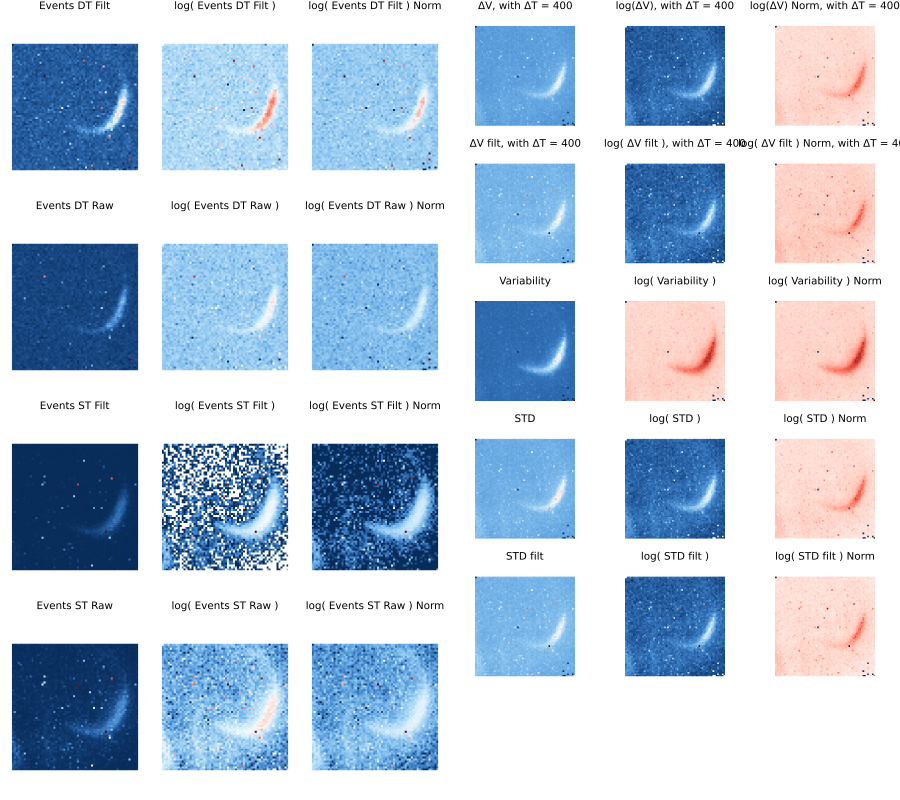

In [87]:
PShadow01 = plot( F1, F9, F5, F11, F13, layout = (6,1) );
PShadow = plot( F3, PShadow01, layout = ( 1, 2 ), wsize = ( 900, 800 ), titlefont = 7 );

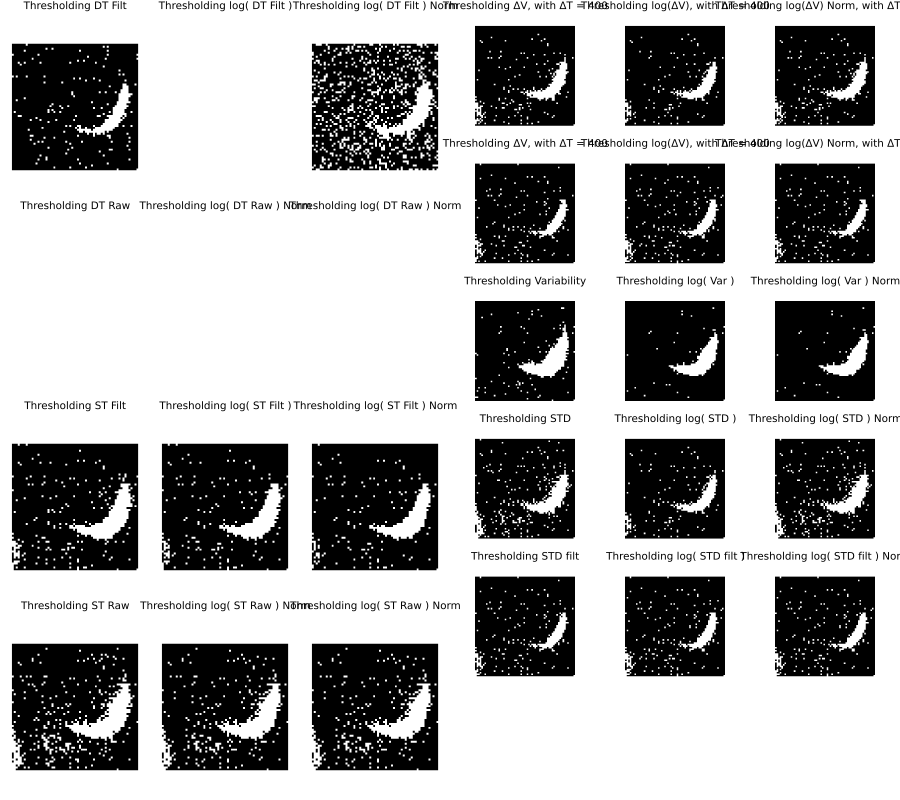

In [88]:
PThr01 = plot( F2, F10, F6, F12, F14, layout = (6,1) );
PThreshold = plot( F4, PThr01, layout = ( 1, 2 ), wsize = ( 900, 800 ), titlefont = 7 )

In [93]:
AllSelections = [ ];
push!( AllSelections, SelectedChannelsTDTEFilt )
push!( AllSelections, SelectedChannelsTDTEFiltlog )
push!( AllSelections, SelectedChannelsTDTEFiltlog0 )
push!( AllSelections, SelectedChannelsTDTERaw )
push!( AllSelections, SelectedChannelsTDTERawlog )
push!( AllSelections, SelectedChannelsTDTERawlog0 )
push!( AllSelections, SelectedChannelsTSTEFilt )
push!( AllSelections, SelectedChannelsTSTEFiltlog )
push!( AllSelections, SelectedChannelsTSTEFiltlog0 )
push!( AllSelections, SelectedChannelsTSTERaw )
push!( AllSelections, SelectedChannelsTSTERawlog )
push!( AllSelections, SelectedChannelsTSTEFiltlog0 )
push!( AllSelections, SelectedChannelsTSTD )
push!( AllSelections, SelectedChannelsTSTDlog )
push!( AllSelections, SelectedChannelsTSTDlog0 )
push!( AllSelections, SelectedChannelsTSTDF )
push!( AllSelections, SelectedChannelsTSTDFlog )
push!( AllSelections, SelectedChannelsTSTDFlog0 )
push!( AllSelections, SelectedChannelsTV )
push!( AllSelections, SelectedChannelsTVlog )
push!( AllSelections, SelectedChannelsTVlog0 )
push!( AllSelections, SelectedChannelsTVF )
push!( AllSelections, SelectedChannelsTVFlog )
push!( AllSelections, SelectedChannelsTVFlog0 )
push!( AllSelections, SelectedChannelsTΔV01F )
push!( AllSelections, SelectedChannelsTΔV01Flog )
push!( AllSelections, SelectedChannelsTΔV01Flog0 )
push!( AllSelections, SelectedChannelsTΔV01 )
push!( AllSelections, SelectedChannelsTΔV01log )
push!( AllSelections, SelectedChannelsTΔV01log0 );

In [99]:
aux = findall( length.( AllSelections ) .!= nChs );
AllSelections = AllSelections[ aux ];
SelectionIslas = [ ]
for a in AllSelections
    _, g = GetGroups( a );
    push!( SelectionIslas, g )
end
aux = countmap( vcat( vcat( SelectionIslas... )...) );
K = Int.( keys( aux ) );
V = Int.( values( aux ) );
W = zeros( Int, nChs );
W[ K ] .= V;
FinalPlot = Zplot( log.( W ), "W" );
Todos, t = Thresholding( log.( W ) );
NewT = Todos[ :, vec( sum( Todos , dims = 1 ) ) .!= maximum( vec( sum( Todos , dims = 1 ) ) ) ];
NewW = vec( sum( NewT, dims = 2 ) );
FinalSelection = findall( NewW .!= 0 );

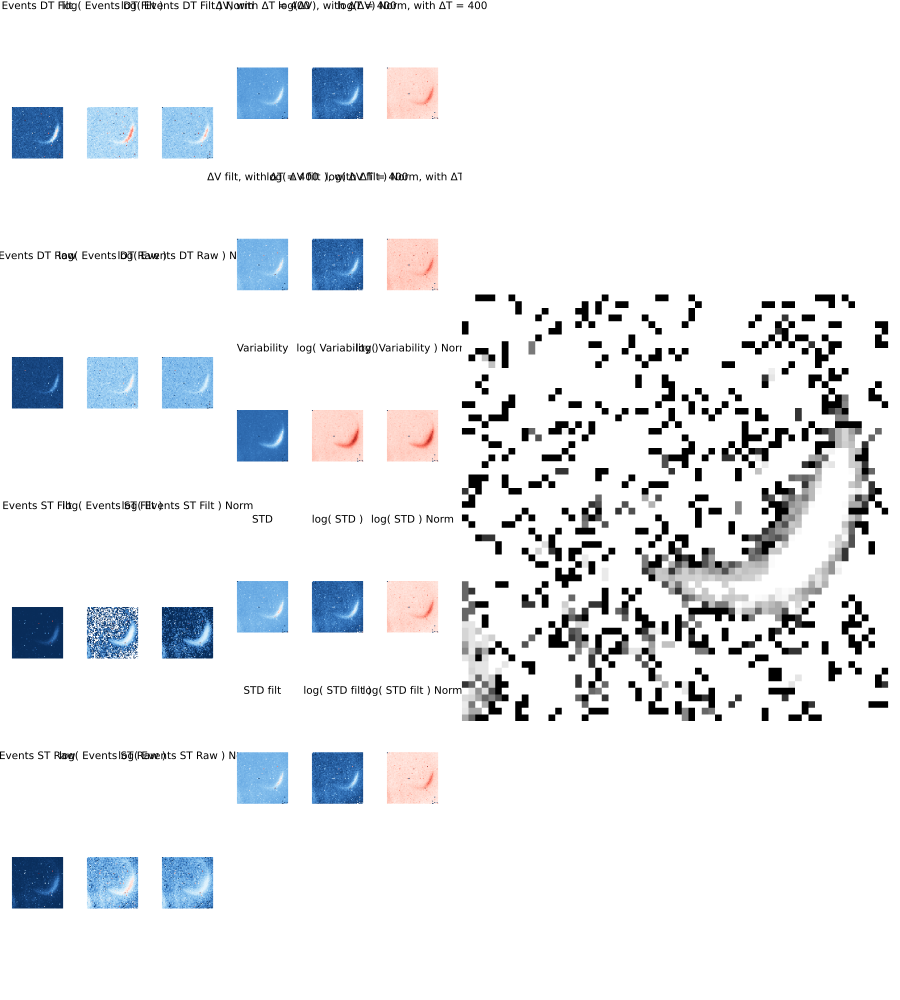

In [168]:
plot( PShadow, FinalPlot, wsize = (900, 1000), cbar = :none)

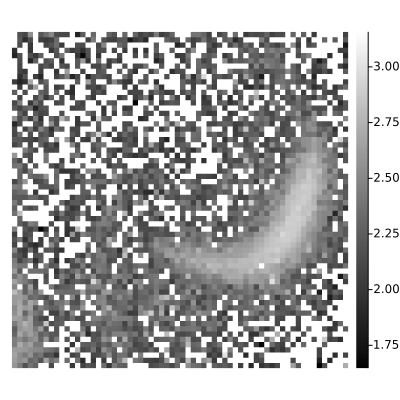

In [176]:
WF[ WF .== -Inf ] .= 0;
Zplot( log.( WF ), "W" )

In [177]:
Todos, t = Thresholding( log.( WF ) );

In [181]:
WWF = vec(sum( Todos, dims = 2));

In [182]:
Todos, t = Thresholding( WWF );

In [198]:
aux = Todos[ :, 500 .< vec(sum( Todos, dims = 1)) .< 1500 ];

In [228]:
x1 = findall( vec( sum( aux , dims = 2 ) ) .!= 0 );

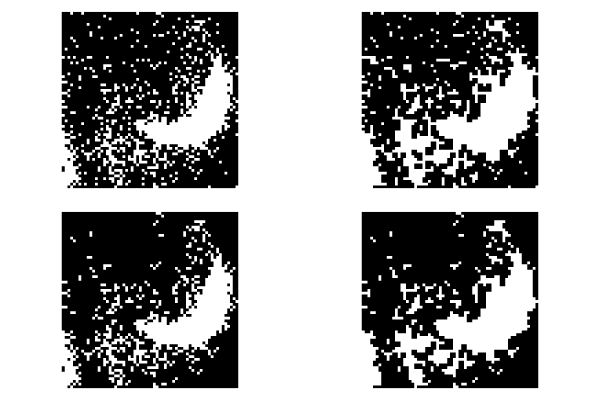

In [244]:
plot( 
    Zplot( x1, "0" ), 
    Zplot( x2, "0" ), 
    Zplot( x3, "0" ), 
    Zplot( x4, "0" ), 
    layout = (2,2),
    cbar = :none)

In [240]:
x2 = FillingHolesCrux( x1 );

l, x3 = GetGroups( x1 );

x3 = vcat( x3... );

x4 = FillingHolesCrux( x3 );

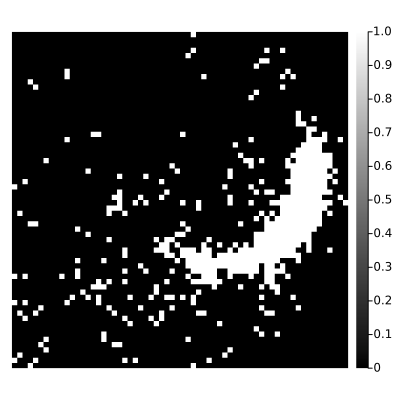

In [343]:
new = x3[ DTEFiltlog[ x3 ] .>= median( DTEFiltlog[ x3 ] ) ];
Zplot( new, "0")

In [347]:
NN = setdiff(setdiff(channels, DiscardedChannels), new);

In [353]:
xx = copy( STERawlog );

In [356]:
YANO = setdiff(channels,NN);

In [358]:
xx[YANO] .= minimum(xx);

In [359]:
a, b = Thresholding(xx);

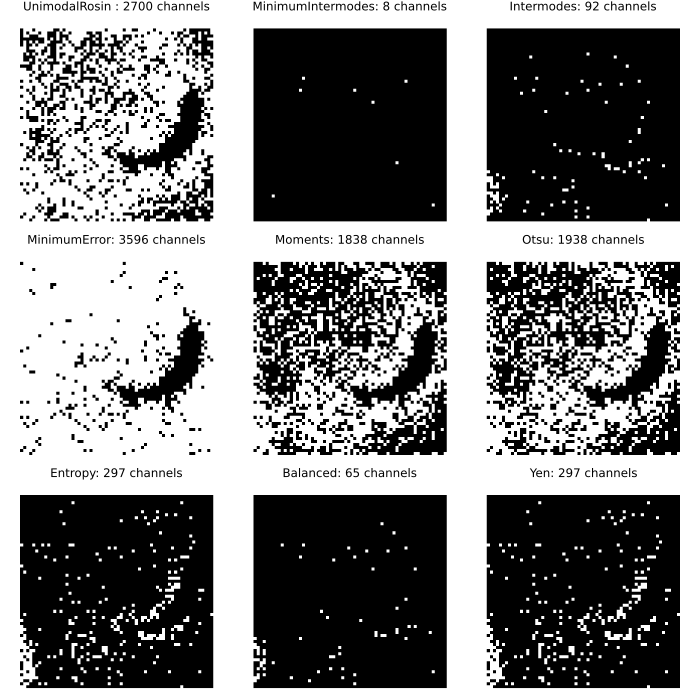

In [360]:
ThresholdingPlots(a)

FillingHolesCrux

In [362]:
l, g = GetGroups(x1);

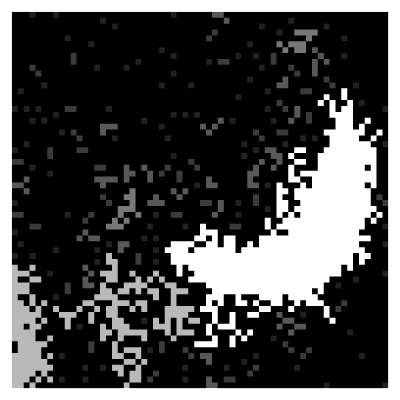

In [365]:
FigureGroups( g, l, :greys)

29.65159377316531

In [378]:
new = x1[DTEFilt[x1] .> median(DTEFilt[x1])];

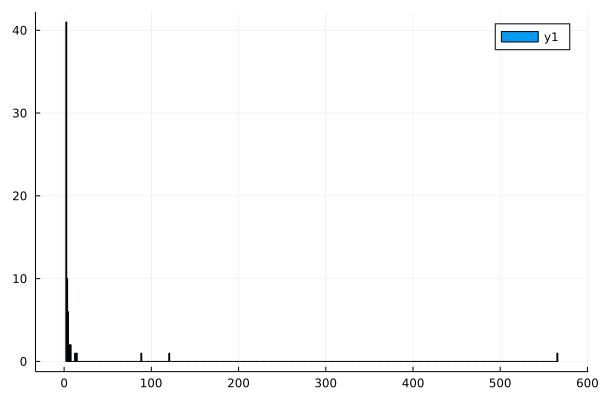

In [382]:
histogram(length.(g))

In [ ]:
# # •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
# using StatsBase
# function DesatNegativePositive( limite::Float64, BIN::Matrix{Float64} )
#     limite = size( BIN, 2 )*limite;
#     AUX = findall( BIN .== minimum( BIN ) );
#     AUX = getindex.( AUX, [ 1 2 ] );
#     NegativeSaturatedChannels = unique( AUX[ :, 1 ] );
#     NSFxC = Int.( values( countmap( AUX[ :, 1 ] ) ) );
#     NSC = Int.( keys( countmap( AUX[ :, 1 ] ) ) );
#     DiscardedChannelsN = NSC[ NSFxC .>= limite ];
#     earth = NSC[ NSFxC .== maximum( NSFxC ) ][ 1 ];
#     BIN[ earth, : ] .= 0;
#     AUX = findall( BIN .== maximum( BIN ) );
#     AUX = getindex.( AUX, [ 1 2 ] );
#     PositiveSaturatedChannels = unique( AUX[ :, 1 ] );
#     PSFxC = Int.( values( countmap( AUX[ :, 1 ] ) ) );
#     PSC = Int.( keys( countmap( AUX[ :, 1 ] ) ) );
#     DiscardedChannelsP = PSC[ PSFxC .>= limite ];
#     DiscardedChannels = union( DiscardedChannelsN, DiscardedChannelsP );
#     BIN[ DiscardedChannels, : ] .= 0;
#     return earth, DiscardedChannels, BIN
# end
# using Distributions, Statistics
# function remover_canales( data::Matrix{Float64}, thr::Real )
#     # calcula aquellos canales cuya desviacion estandar no se comporta como la media.
#     # depende del paquete Statistics y Distributions
#     desviaciones = std( Float64.( data ), dims = 2 );
#     z = fit( Normal, desviaciones );
#     limite_derecha = z.μ + thr*z.σ; limite_izquierda = z.μ - thr*z.σ;
#     temp = findall( limite_izquierda .< desviaciones .< limite_derecha );
#     canales_buenos = zeros( Int, length( temp ) );
#     [ canales_buenos[ i, 1 ] = temp[ i ].I[ 1 ] for i in 1:length( temp ) ];
#     No_chs = setdiff( 1:size( data, 1 ), canales_buenos );
#     return canales_buenos, No_chs
# end